In [1]:
#!pip3 install airportsdata

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import airportsdata
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
df = pd.read_csv("bookingsData.csv")

/var/folders/jj/3_60j1tx1ys_rfzl_xtzxnnm0000gp/T/ipykernel_17753/880627931.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("bookingsData.csv")


In [4]:
df.head()

,Unnamed: 0,PNR,PNR_CREATE_DT,NUM_IN_PARTY,CHANNEL,ORIGIN,DEST,OD,NUM_SEGMENTS,PNR_DEPARTURE_DATE,...,departure_month_name,LENGTH_OF_STAY,WEEKEND_DEPARTURE,WEEKEND_ARRIVAL,TRAVEL_DISTANCE,Distance_Bin,Holiday_Departure,Holiday_Return,Cumulative_Booking_Count,BOOKING_WINDOW
0,80521,A196441,2022-06-28,2,DIRECT,ABE,BOS,ABE-BOS,2,2022-07-01,...,July,3 days,True,0.0,258.0,0-500,NaN,Independence Day,0,1-7 days
1,84806,A206961,2022-06-28,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-01,...,July,NaN,True,NaN,258.0,0-500,NaN,NaN,1,1-7 days
2,280773,A688913,2022-06-30,1,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-02,...,July,NaN,True,NaN,258.0,0-500,Independence Day,NaN,0,1-7 days
3,16303,A40023,2022-07-01,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-02,...,July,NaN,True,NaN,258.0,0-500,Independence Day,NaN,1,1-7 days
4,251373,A616680,2022-07-01,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-03,...,July,NaN,True,NaN,258.0,0-500,Independence Day,NaN,0,1-7 days


In [5]:
df = df.drop(columns = {'Unnamed: 0'})

In [6]:
df.Holiday_Return.value_counts()

Holiday_Return
Labor Day                     4326
Veterans Day                  3301
Thanksgiving                  2924
New Year's Day (observed)     2456
Christmas Day (observed)      1386
New Year's Day                 791
Independence Day               471
Martin Luther King Jr. Day     268
Christmas Day                  118
Washington's Birthday            2
Name: count, dtype: int64

### Correcting travel distance

In [7]:
# !pip install airportsdata

In [8]:
airports = airportsdata.load('IATA')
# Assume `airport_dict` is the dictionary containing airport data
airport_df = pd.DataFrame.from_dict(airports, orient='index')
airport_df = airport_df.reset_index().rename(columns={'index': 'airport_code'})

# Keep only necessary columns for merging (e.g., 'airport_code', 'lat', 'lon')
airport_df = airport_df[['iata', 'lat', 'lon']].rename(columns={'iata': 'airport_code'})

In [9]:
# Merge origin coordinates
df = df.merge(airport_df.rename(columns={'airport_code': 'ORIGIN', 'lat': 'Origin_Lat', 'lon': 'Origin_Lon'}),
              on='ORIGIN', how='left')

# Merge destination coordinates
df = df.merge(airport_df.rename(columns={'airport_code': 'DEST', 'lat': 'Dest_Lat', 'lon': 'Dest_Lon'}),
              on='DEST', how='left')

In [10]:
# Convert latitude and longitude from degrees to radians
df['Origin_Lat_rad'] = np.radians(df['Origin_Lat'])
df['Origin_Lon_rad'] = np.radians(df['Origin_Lon'])
df['Dest_Lat_rad'] = np.radians(df['Dest_Lat'])
df['Dest_Lon_rad'] = np.radians(df['Dest_Lon'])

# Haversine formula for distance calculation
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 3958.8  # Radius of Earth in miles
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Calculate distance using the haversine formula
df['Calculated_Travel_Distance'] = haversine_distance(df['Origin_Lat_rad'], df['Origin_Lon_rad'], 
                                                      df['Dest_Lat_rad'], df['Dest_Lon_rad'])
df['Calculated_Travel_Distance'] = df['Calculated_Travel_Distance'].round(2)

In [11]:
df.columns

Index(['PNR', 'PNR_CREATE_DT', 'NUM_IN_PARTY', 'CHANNEL', 'ORIGIN', 'DEST',
       'OD', 'NUM_SEGMENTS', 'PNR_DEPARTURE_DATE', 'PNR_RETURN_DATE',
       'BUSINESS_PROBABILITY', 'BLEISURE_PROBABILITY', 'VFR_PROBABILITY',
       'VACATION_PROBABILITY', 'PERSONAL_PROBABILITY', 'REVENUE',
       'ADVANCED_PURCHASE', 'ROUNDTRIP', 'NONSTOP', 'REVENUE_PER_PERSON',
       'TRAVEL_TYPE', 'departure_month', 'departure_month_name',
       'LENGTH_OF_STAY', 'WEEKEND_DEPARTURE', 'WEEKEND_ARRIVAL',
       'TRAVEL_DISTANCE', 'Distance_Bin', 'Holiday_Departure',
       'Holiday_Return', 'Cumulative_Booking_Count', 'BOOKING_WINDOW',
       'Origin_Lat', 'Origin_Lon', 'Dest_Lat', 'Dest_Lon', 'Origin_Lat_rad',
       'Origin_Lon_rad', 'Dest_Lat_rad', 'Dest_Lon_rad',
       'Calculated_Travel_Distance'],
      dtype='object')

In [12]:
df = df.drop(columns = ['Origin_Lat', 'Origin_Lon',
       'Dest_Lat', 'Dest_Lon', 'Origin_Lat_rad', 'Origin_Lon_rad',
       'Dest_Lat_rad', 'Dest_Lon_rad','TRAVEL_DISTANCE'])

In [13]:
df.rename(columns = {'Calculated_Travel_Distance':'TRAVEL_DISTANCE'}, inplace = True)

In [14]:
df.head()

,PNR,PNR_CREATE_DT,NUM_IN_PARTY,CHANNEL,ORIGIN,DEST,OD,NUM_SEGMENTS,PNR_DEPARTURE_DATE,PNR_RETURN_DATE,...,departure_month_name,LENGTH_OF_STAY,WEEKEND_DEPARTURE,WEEKEND_ARRIVAL,Distance_Bin,Holiday_Departure,Holiday_Return,Cumulative_Booking_Count,BOOKING_WINDOW,TRAVEL_DISTANCE
0,A196441,2022-06-28,2,DIRECT,ABE,BOS,ABE-BOS,2,2022-07-01,2022-07-04,...,July,3 days,True,0.0,0-500,NaN,Independence Day,0,1-7 days,258.03
1,A206961,2022-06-28,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-01,NaN,...,July,NaN,True,NaN,0-500,NaN,NaN,1,1-7 days,258.03
2,A688913,2022-06-30,1,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-02,NaN,...,July,NaN,True,NaN,0-500,Independence Day,NaN,0,1-7 days,258.03
3,A40023,2022-07-01,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-02,NaN,...,July,NaN,True,NaN,0-500,Independence Day,NaN,1,1-7 days,258.03
4,A616680,2022-07-01,2,DIRECT,ABE,BOS,ABE-BOS,1,2022-07-03,NaN,...,July,NaN,True,NaN,0-500,Independence Day,NaN,0,1-7 days,258.03


### Filter irrelevant data

In [15]:
df.shape

(2249589, 32)

In [16]:
df = df[df['ORIGIN'] !=df['DEST']]

In [17]:
df.shape

(2249557, 32)

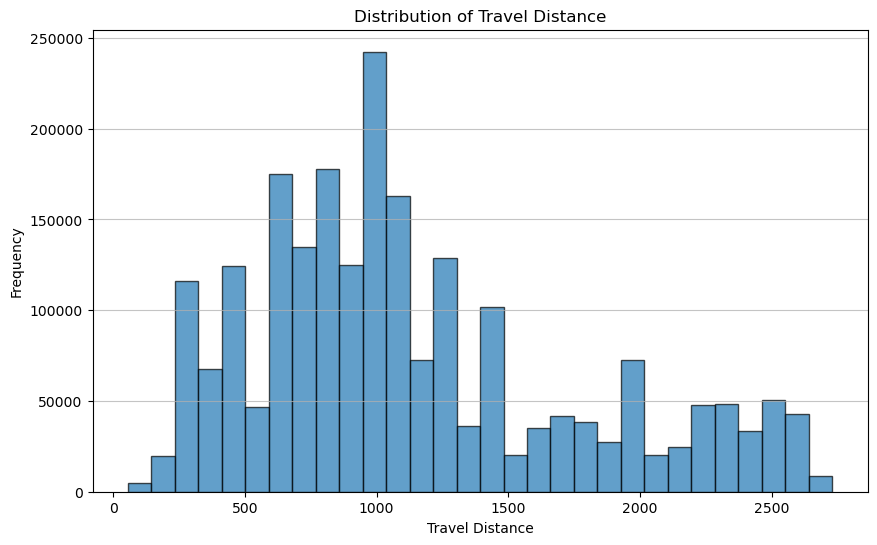

In [18]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['TRAVEL_DISTANCE'].dropna(), bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Travel Distance')
plt.xlabel('Travel Distance')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [19]:
df.Distance_Bin.value_counts()

Distance_Bin
500-1000     708414
1000-1500    616656
0-500        330333
2000-3000    278914
1500-2000    226152
Name: count, dtype: int64

In [20]:
distance_bins = [0,250,500, 750, 1000, 1250, 1500, 2000, 3000, float('inf')]
distance_labels = ['0-250','250-500','500-750','750-1000','1000-1250', '1250-1500', '1500-2000', '2000-3000', '3000+']
df['Distance_Bin'] = pd.cut(df['TRAVEL_DISTANCE'], bins=distance_bins, labels=distance_labels)

### Capturing Willingness to Pay by adding Interaction features and more columns

1. Revenue and Price columns

In [21]:
df['RPM'] = df['REVENUE_PER_PERSON'] / df['TRAVEL_DISTANCE']
#df['Inverse_AP'] = 1 / df['ADVANCED_PURCHASE']

In [22]:
df['RPM_CumulativeBookings_Interaction'] = df['RPM'] * (df['Cumulative_Booking_Count']+1)# Weekend Interaction: Captures WTP for trips with either weekend departure or arrival

#df2['Weekend_Trip_Revenue_Interaction'] = (df2['WEEKEND_DEPARTURE'] | df2['WEEKEND_ARRIVAL']) * df2['REVENUE_PER_PERSON']

# Holiday Interaction: Captures WTP for trips with either holiday departure or return
#df2['Holiday_Trip_Revenue_Interaction'] = (df2['Holiday_Departure'].notna() | df2['Holiday_Return'].notna()) * df2['REVENUE_PER_PERSON']
#df2['Nonstop_Revenue_Interaction'] = df2['NONSTOP'] * df2['REVENUE_PER_PERSON']

`Revenue_AP_Ratio`

Higher values of Revenue_AP_Ratio imply higher WTP due to more urgency and willingness to pay despite minimal advance purchase time

In [23]:
df['Revenue_AP_Ratio'] = df['RPM'] / (df['ADVANCED_PURCHASE'] + 1)

`Distance_Adjusted_Revenue`

how much a customer pays relative to the typical price within their distance bin. This approach identifies customers willing to pay a premium over the norm for their travel distance, which is a strong WTP indicator.

In [24]:
# Calculate average revenue per distance bin
avg_revenue_per_bin = df.groupby('Distance_Bin')['REVENUE_PER_PERSON'].transform('mean')
df['Distance_Adjusted_Revenue'] = df['REVENUE_PER_PERSON'] / avg_revenue_per_bin

/var/folders/jj/3_60j1tx1ys_rfzl_xtzxnnm0000gp/T/ipykernel_17753/3843558282.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_revenue_per_bin = df.groupby('Distance_Bin')['REVENUE_PER_PERSON'].transform('mean')


`Cumulative_Advance_Purchase_Ratio`

a higher cumulative count with a shorter AP signals a higher WTP, as demand is driving up booking rates.

In [25]:
df['Cumulative_Advance_Purchase_Ratio'] = df['Cumulative_Booking_Count'] + 1/ (df['ADVANCED_PURCHASE'] + 1)

`Channel_RPM_Ratio`

reflect the willingness to pay per mile relative to the average for each booking channel

In [26]:
avg_rpm_per_channel = df.groupby('CHANNEL')['RPM'].transform('mean')

# Calculate Channel-Based RPM Premium (Channel_RPM_Ratio)
df['Channel_RPM_Ratio'] = df['RPM'] / avg_rpm_per_channel

In [27]:
df.Channel_RPM_Ratio.isna().sum()

0

In [28]:
df.Distance_Adjusted_Revenue.isna().sum()

0

#### Converting WEEKEND_ARRIVAL, WEEKEND_DEPARTURE, Holiday_Departure, Holiday_Return, ROUNDTRIP, NONSTOP Data types

In [29]:
#df['WEEKEND_ARRIVAL'].unique()

In [30]:
# Replace NaN values with 0 in WEEKEND_ARRIVAL
# NaN values in pandas are represented as np.nan (special floating-point value), not as the string 'NaN'
df['WEEKEND_ARRIVAL'].fillna(0, inplace=True)
df['WEEKEND_ARRIVAL'].unique()

array([0., 1.])

In [31]:
# Convert WEEKEND_DEPARTURE from bool to integer
df['WEEKEND_DEPARTURE'] = df['WEEKEND_DEPARTURE'].astype(int)
print(df['WEEKEND_DEPARTURE'].dtype)

int64


In [32]:
# Convert Holiday_Departure: NaN becomes 0, others become 1
df['Holiday_Departure'] = np.where(df['Holiday_Departure'].isna(), 0, 1).astype(int)
df['Holiday_Departure'].unique()

array([0, 1])

In [33]:
# Conver Holiday_Return: nan -> 0, else ->1
df['Holiday_Return'] = np.where(df['Holiday_Return'].isna(), 0, 1).astype(int)
df['Holiday_Return'].unique()

array([1, 0])

In [34]:
df['Holiday'] = df[['Holiday_Departure', 'Holiday_Return']].max(axis=1)
df['Weekend'] = df[['WEEKEND_DEPARTURE', 'WEEKEND_ARRIVAL']].max(axis=1)

In [35]:
#Convert ROUNDTRIP from boolean to integer
#df['ROUNDTRIP'] = df['ROUNDTRIP'].astype(int)
#print(df['ROUNDTRIP'].dtype)

In [36]:
#Covert NONSTOP from boolean to integer
#df['NONSTOP'] = df['NONSTOP'].astype(int)
#print(df['NONSTOP'].dtype)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2249557 entries, 0 to 2249588
Data columns (total 40 columns):
 #   Column                              Dtype   
---  ------                              -----   
 0   PNR                                 object  
 1   PNR_CREATE_DT                       object  
 2   NUM_IN_PARTY                        int64   
 3   CHANNEL                             object  
 4   ORIGIN                              object  
 5   DEST                                object  
 6   OD                                  object  
 7   NUM_SEGMENTS                        int64   
 8   PNR_DEPARTURE_DATE                  object  
 9   PNR_RETURN_DATE                     object  
 10  BUSINESS_PROBABILITY                float64 
 11  BLEISURE_PROBABILITY                float64 
 12  VFR_PROBABILITY                     float64 
 13  VACATION_PROBABILITY                float64 
 14  PERSONAL_PROBABILITY                float64 
 15  REVENUE                             f

In [38]:
df2 = df.copy()

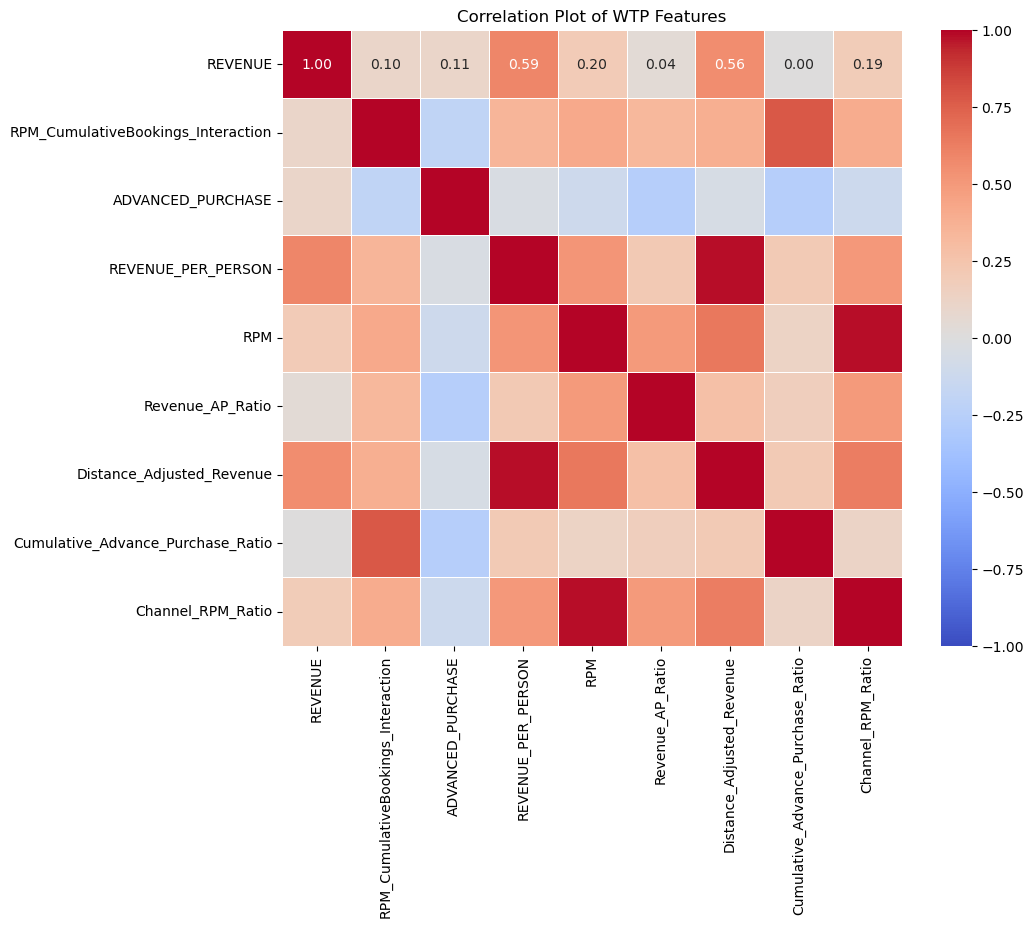

In [39]:
# Correlation analysis
correlation_features = ['REVENUE','RPM_CumulativeBookings_Interaction','ADVANCED_PURCHASE',
                            'REVENUE_PER_PERSON', 'RPM', 'Revenue_AP_Ratio', 
                            'Distance_Adjusted_Revenue', 'Cumulative_Advance_Purchase_Ratio', 'Channel_RPM_Ratio']

correlation_matrix = df2[correlation_features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)
plt.title("Correlation Plot of WTP Features")
plt.show()


In [40]:
# Calculate deviation from the average RPM within each channel
#std_rpm_per_channel = df.groupby('CHANNEL')['RPM'].transform('std')
#df['Channel_RPM_Deviation'] = (df['RPM'] - avg_rpm_per_channel) / std_rpm_per_channel

In [41]:
#df.Channel_RPM_Deviation.corr(df.RPM)

In [42]:
df2[correlation_features].isna().sum()

REVENUE                               0
RPM_CumulativeBookings_Interaction    0
ADVANCED_PURCHASE                     0
REVENUE_PER_PERSON                    0
RPM                                   0
Revenue_AP_Ratio                      0
Distance_Adjusted_Revenue             0
Cumulative_Advance_Purchase_Ratio     0
Channel_RPM_Ratio                     0
dtype: int64

### CLUSTERING

In [43]:
df2.columns

Index(['PNR', 'PNR_CREATE_DT', 'NUM_IN_PARTY', 'CHANNEL', 'ORIGIN', 'DEST',
       'OD', 'NUM_SEGMENTS', 'PNR_DEPARTURE_DATE', 'PNR_RETURN_DATE',
       'BUSINESS_PROBABILITY', 'BLEISURE_PROBABILITY', 'VFR_PROBABILITY',
       'VACATION_PROBABILITY', 'PERSONAL_PROBABILITY', 'REVENUE',
       'ADVANCED_PURCHASE', 'ROUNDTRIP', 'NONSTOP', 'REVENUE_PER_PERSON',
       'TRAVEL_TYPE', 'departure_month', 'departure_month_name',
       'LENGTH_OF_STAY', 'WEEKEND_DEPARTURE', 'WEEKEND_ARRIVAL',
       'Distance_Bin', 'Holiday_Departure', 'Holiday_Return',
       'Cumulative_Booking_Count', 'BOOKING_WINDOW', 'TRAVEL_DISTANCE', 'RPM',
       'RPM_CumulativeBookings_Interaction', 'Revenue_AP_Ratio',
       'Distance_Adjusted_Revenue', 'Cumulative_Advance_Purchase_Ratio',
       'Channel_RPM_Ratio', 'Holiday', 'Weekend'],
      dtype='object')

In [44]:
feature_to_scale = ['VACATION_PROBABILITY', 'PERSONAL_PROBABILITY', 'VFR_PROBABILITY',
                     'Distance_Adjusted_Revenue','ADVANCED_PURCHASE','Cumulative_Booking_Count',
                     'RPM','RPM_CumulativeBookings_Interaction','Revenue_AP_Ratio','departure_month',
                     'Cumulative_Advance_Purchase_Ratio']

In [45]:
primary_features = feature_to_scale + ['Holiday','Weekend','ROUNDTRIP','NONSTOP']

In [46]:
primary_features

['VACATION_PROBABILITY',
 'PERSONAL_PROBABILITY',
 'VFR_PROBABILITY',
 'Distance_Adjusted_Revenue',
 'ADVANCED_PURCHASE',
 'Cumulative_Booking_Count',
 'RPM',
 'RPM_CumulativeBookings_Interaction',
 'Revenue_AP_Ratio',
 'departure_month',
 'Cumulative_Advance_Purchase_Ratio',
 'Holiday',
 'Weekend',
 'ROUNDTRIP',
 'NONSTOP']

<b> Standardization / Scaling </b>

In [47]:
# Define the weights for the specific features
weight_features = ['RPM','Distance_Adjusted_Revenue','ADVANCED_PURCHASE',
                   'Revenue_AP_Ratio']

weights = {feature: 2 for feature in weight_features}  # Multiply these features by a weight of 2

# Standardizing features
scaler = StandardScaler()
df2[feature_to_scale] = scaler.fit_transform(df2[feature_to_scale])

# Apply weights to the scaled features
for feature, weight in weights.items():
    df2[feature] *= weight

In [48]:
df2[feature_to_scale].head()

,VACATION_PROBABILITY,PERSONAL_PROBABILITY,VFR_PROBABILITY,Distance_Adjusted_Revenue,ADVANCED_PURCHASE,Cumulative_Booking_Count,RPM,RPM_CumulativeBookings_Interaction,Revenue_AP_Ratio,departure_month,Cumulative_Advance_Purchase_Ratio
0,-0.623937,-0.103495,1.121879,-1.163893,-1.644434,-0.580061,1.588614,-0.410600,1.537873,-1.425953,-0.577062
1,-0.917957,-0.541312,1.605440,-1.598335,-1.644434,-0.561664,0.674559,-0.400822,0.993198,-1.425953,-0.558680
2,-0.857469,1.567282,0.257606,-0.917949,-1.683204,-0.580061,2.106074,-0.407939,2.689799,-1.425953,-0.575530
3,-0.474247,-0.149838,0.438671,-1.772168,-1.721974,-0.561664,0.308819,-0.404584,2.235024,-1.425953,-0.554085
4,-0.887713,1.990464,-0.070818,-1.772168,-1.683204,-0.580061,0.308819,-0.417181,1.261846,-1.425953,-0.575530


In [49]:
# Calculate inertia for different numbers of clusters
inertia = []
cluster_range = range(1, 7)  # Test cluster counts from 1 to 20

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df2[primary_features])    # Use weighted scaled data
    inertia.append(kmeans.inertia_)


/Users/Wen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Wen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Wen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Wen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Wen/anaconda3/lib/pyt

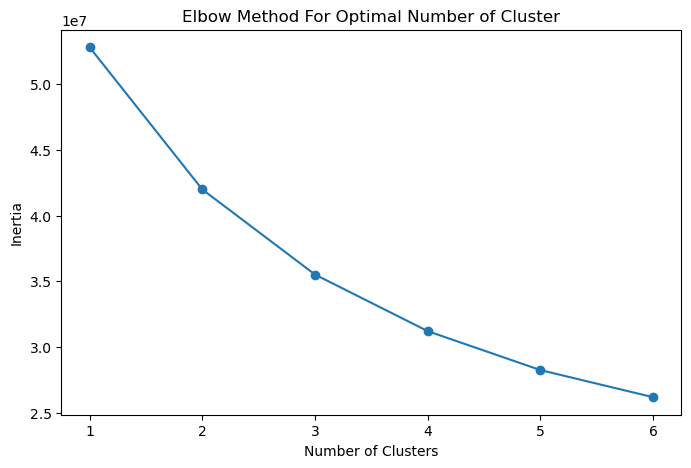

In [50]:
# Plotting the inertia to see the elbow point
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method For Optimal Number of Cluster')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [51]:
# Define the number of clusters based on previous Elbow method
n_clusters = 5

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(df2[primary_features])

# Store the cluster labels in the DataFrame
df2['Cluster'] = labels

/Users/Wen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [52]:
df2['Cluster'] = labels 
df2['Cluster'] = df2['Cluster'] + 1

In [53]:
df['Cluster'] = labels
df['Cluster'] = df['Cluster'] + 1

Alter this to get the summary statistics in a cleaner way for all the necessary variables.

In [54]:
cluster_summary = df.groupby('Cluster').agg({
    'VACATION_PROBABILITY': 'mean',
    'PERSONAL_PROBABILITY': 'mean',
    'VFR_PROBABILITY': 'mean',
    'REVENUE_PER_PERSON': 'mean',
    'ADVANCED_PURCHASE': 'mean',
    'Cumulative_Booking_Count': 'mean',
    'RPM': 'mean',
    'RPM_CumulativeBookings_Interaction': 'mean',
    'Channel_RPM_Ratio': 'mean',
    'Revenue_AP_Ratio': 'mean',
    'Cumulative_Advance_Purchase_Ratio': 'mean',
#    'departure_month': 'mean',
#    'DEST': 'mean',
    'NUM_IN_PARTY': 'mean',
#    'OD': 'mean',
#    'CHANNEL': 'mean', 
#    'ORIGIN': 'mean',
#    'BOOKING_WINDOW': 'mean',
}).reset_index()

In [55]:
cluster_summary

,Cluster,VACATION_PROBABILITY,PERSONAL_PROBABILITY,VFR_PROBABILITY,REVENUE_PER_PERSON,ADVANCED_PURCHASE,Cumulative_Booking_Count,RPM,RPM_CumulativeBookings_Interaction,Channel_RPM_Ratio,Revenue_AP_Ratio,Cumulative_Advance_Purchase_Ratio,NUM_IN_PARTY
0,1,0.329612,0.105506,0.403630,225.800399,13.140486,162.335702,0.239988,40.141556,1.134703,0.058698,162.592048,1.503858
1,2,0.246795,0.098062,0.517044,136.340636,29.377719,17.086163,0.138320,2.656943,0.667354,0.014006,17.190062,2.155138
2,3,0.631927,0.039488,0.263417,158.965878,137.420802,8.680800,0.155161,1.791708,0.736697,0.001292,8.689080,2.748871
3,4,0.160060,0.166196,0.476567,348.818159,1.346563,56.167861,0.900728,46.725683,4.207001,0.553140,56.870673,1.240519
4,5,0.258497,0.099298,0.485146,345.073947,31.948031,27.707557,0.499208,14.011232,2.319073,0.051154,27.820712,1.512791


ANALYZING EACH CLUSTER

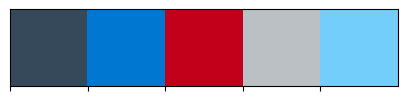

In [56]:
custom_palette = ['#36495A',  # DARK GRAY
                  '#0078D2',  # BLUE
                  '#C30019',  # RED
                  '#bac0c4',  # LIGHT STEEL BLUE
                  '#74CEFB']  # BLACK
sns.palplot(custom_palette)

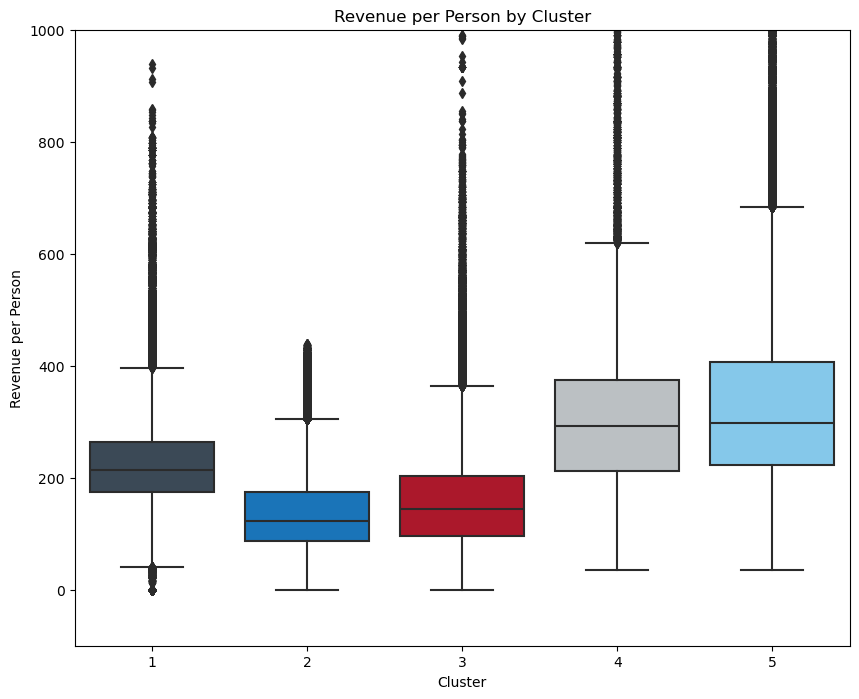

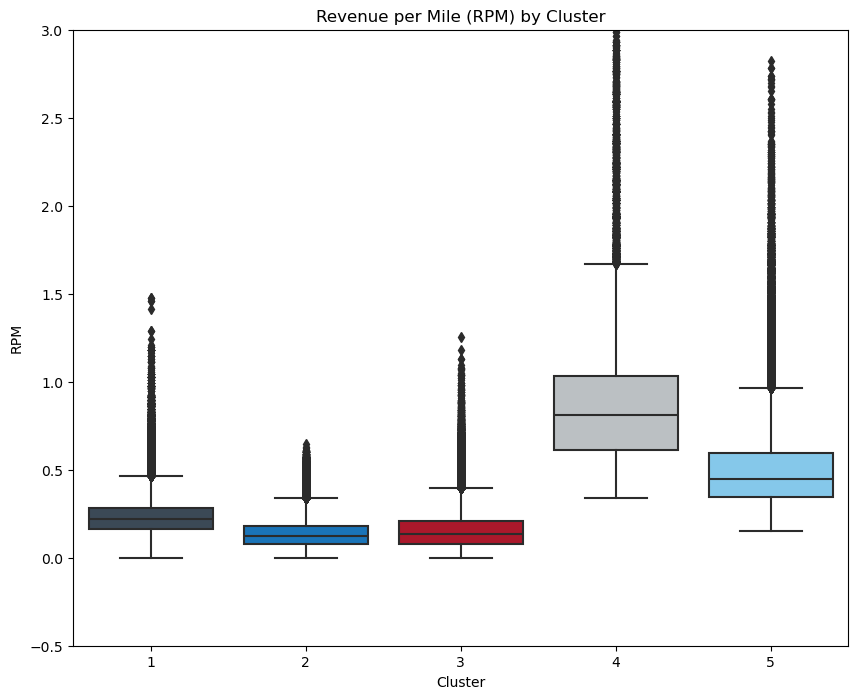

In [57]:
# Boxplot for Revenue per Person by Cluster
plt.figure(figsize=(10, 8))
sns.boxplot(x='Cluster', y='REVENUE_PER_PERSON', data=df, palette = custom_palette)
plt.title('Revenue per Person by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Revenue per Person')
plt.ylim(-100, 1000)    # Set y-axis limits to zoom into the main distribution, excluding extreme outliers
plt.show()

# Repeat for other key features, e.g., RPM, Advanced Purchase
plt.figure(figsize=(10, 8))
sns.boxplot(x='Cluster', y='RPM', data=df, palette = custom_palette)
plt.title('Revenue per Mile (RPM) by Cluster')
plt.xlabel('Cluster')
plt.ylabel('RPM')
plt.ylim(-0.5, 3)
plt.show()


In [58]:
round(df.Cluster.value_counts()*100/len(df),2)

Cluster
2    58.91
3    16.27
5    14.01
1     9.52
4     1.28
Name: count, dtype: float64

In [59]:
df2.Cluster.unique()

array([2, 5, 3, 4, 1])

/Users/Wen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Wen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Wen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Wen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

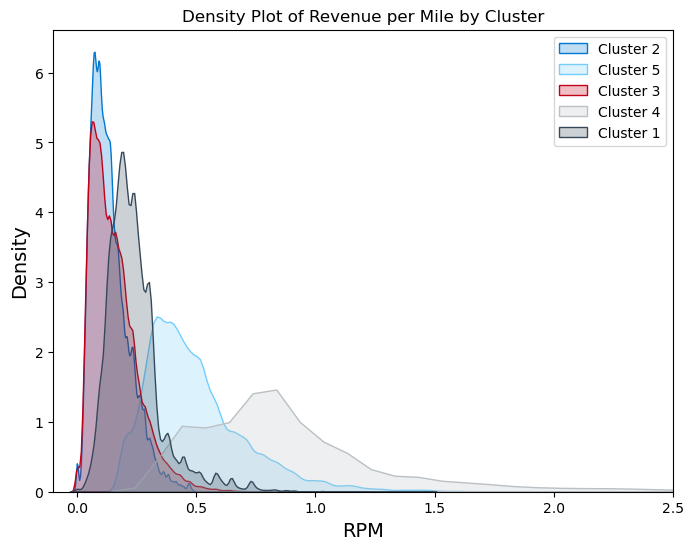

In [60]:
plt.figure(figsize=(8, 6))
for cluster in df2.Cluster.unique():
    sns.kdeplot(df[df['Cluster'] == cluster]['RPM'], label=f'Cluster {cluster}', fill=True, color=custom_palette[cluster-1])
plt.title('Density Plot of Revenue per Mile by Cluster')
plt.xlim([-0.1,2.5])
plt.xlabel('RPM', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.legend()
plt.show()


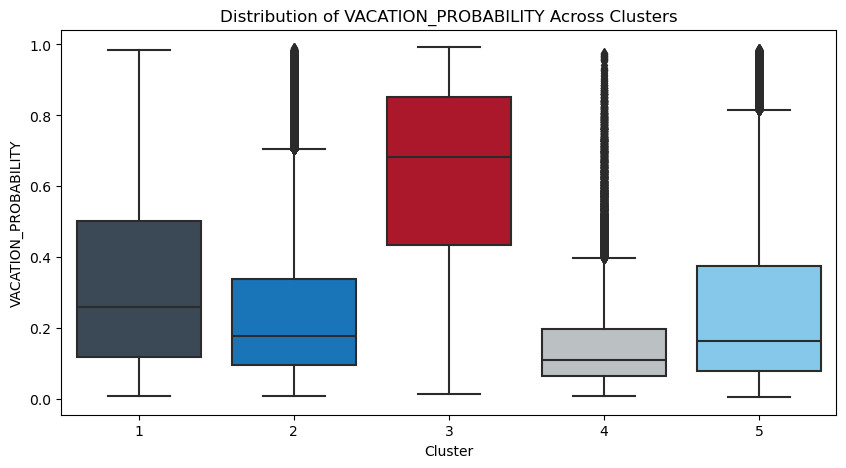

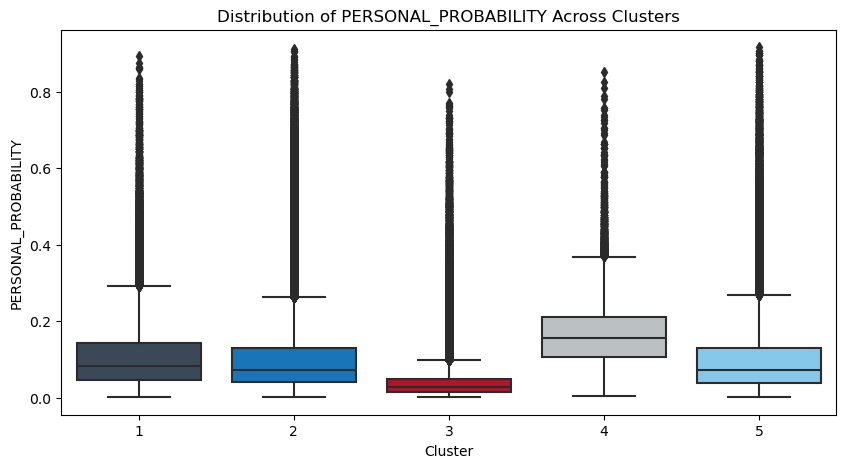

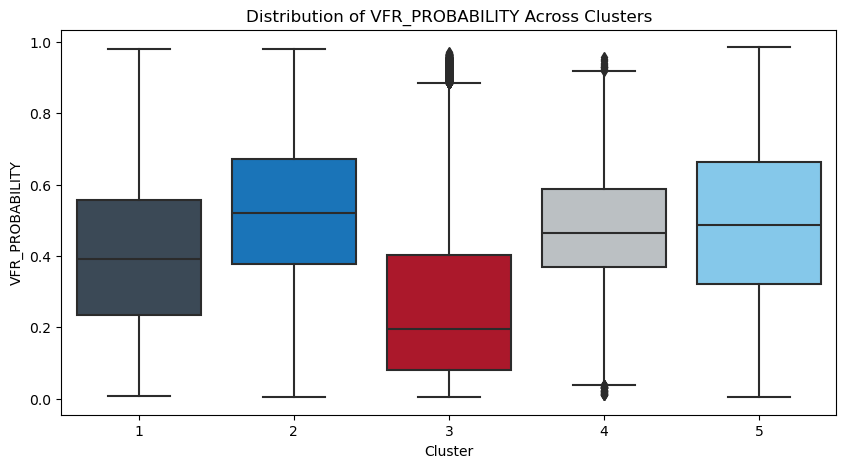

In [61]:
for feature in ['VACATION_PROBABILITY', 'PERSONAL_PROBABILITY', 'VFR_PROBABILITY']:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Cluster', y=feature, data=df, palette = custom_palette)
    plt.title(f'Distribution of {feature} Across Clusters')
    plt.show()

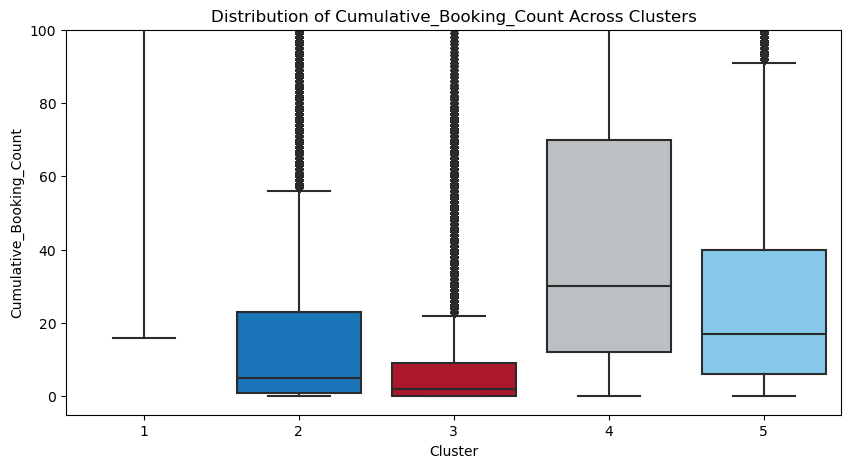

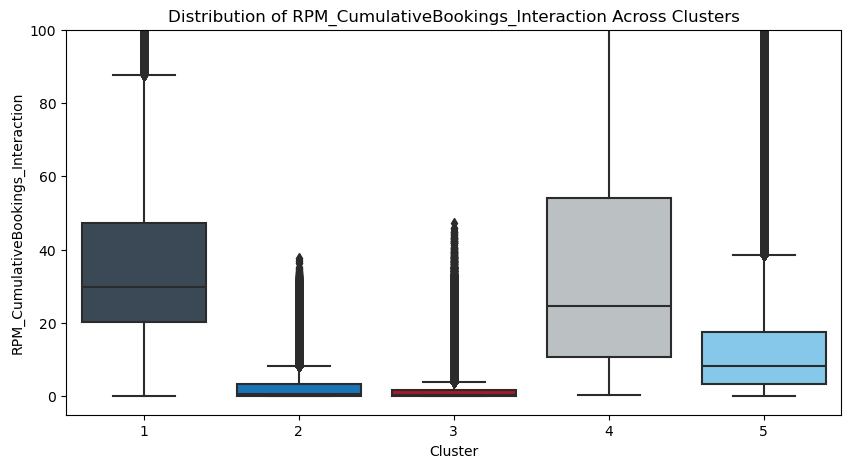

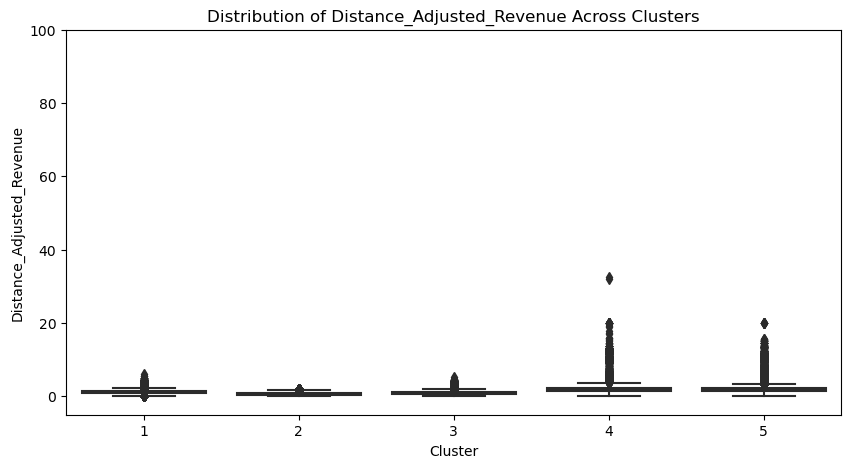

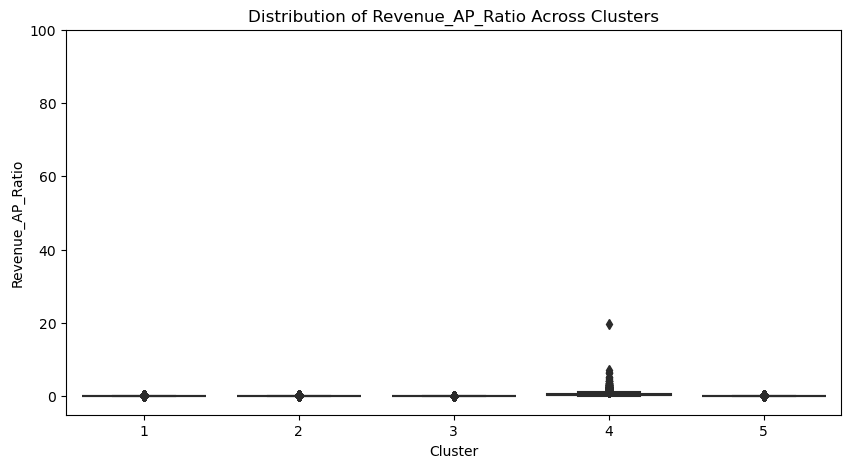

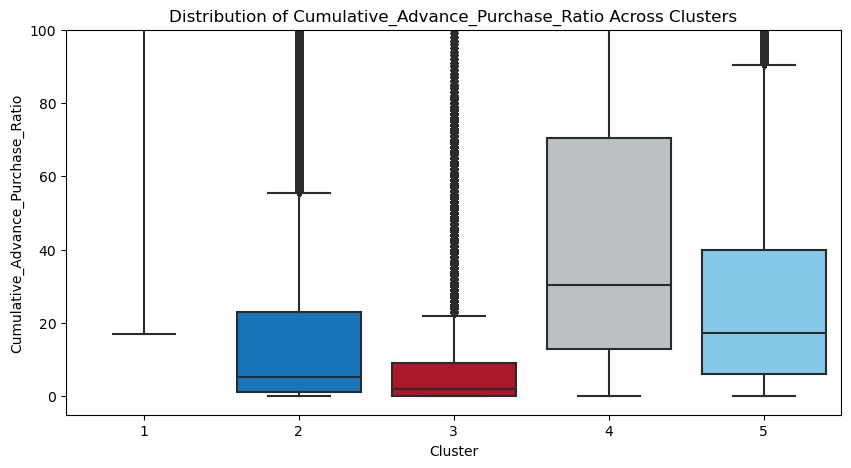

In [62]:
for feature in ['Cumulative_Booking_Count', 'RPM_CumulativeBookings_Interaction', 'Distance_Adjusted_Revenue', 'Revenue_AP_Ratio', 'Cumulative_Advance_Purchase_Ratio']:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Cluster', y=feature, data=df, palette = custom_palette)
    plt.title(f'Distribution of {feature} Across Clusters')
    plt.ylim(-5, 100)
    plt.show()

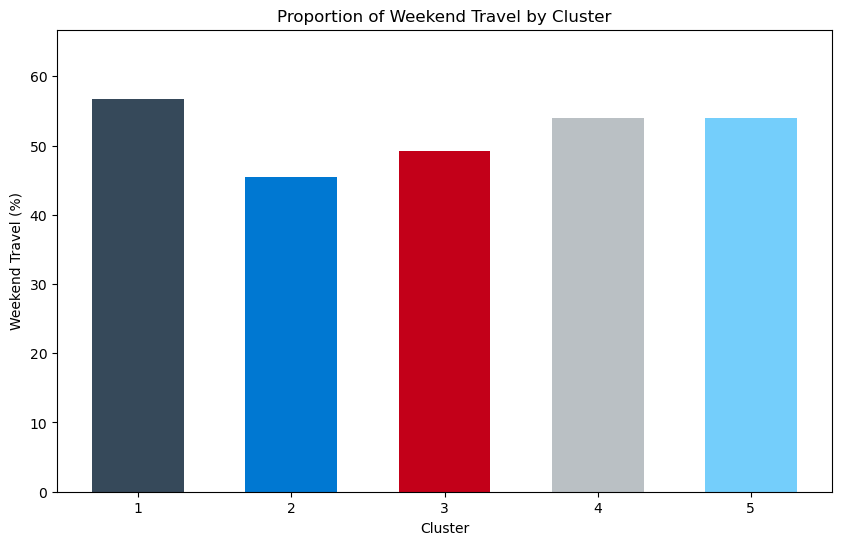

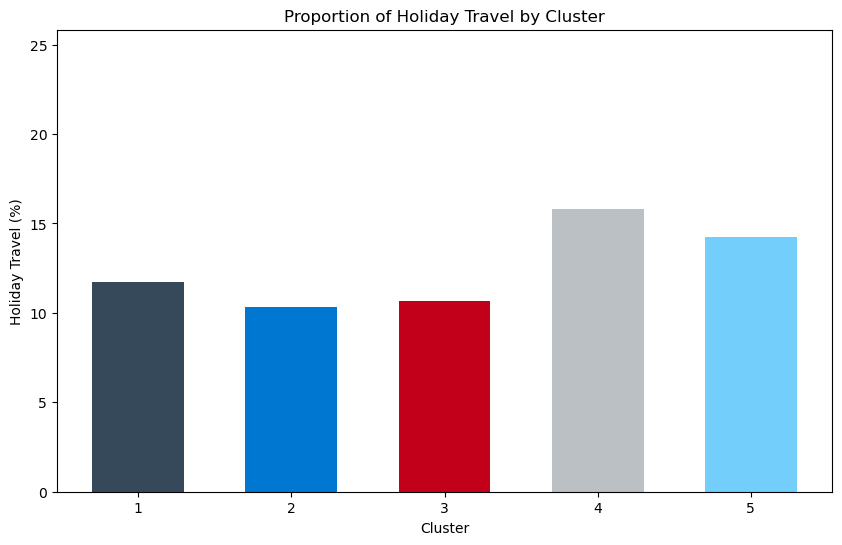

In [63]:
# Calculate the percentage of Weekend travel for each cluster
weekend_percentage = df.groupby('Cluster')['Weekend'].mean() * 100

# Plot Weekend travel percentage by cluster
plt.figure(figsize=(10, 6))
plt.bar(weekend_percentage.index, weekend_percentage.values, color=custom_palette, width = 0.6)

plt.title("Proportion of Weekend Travel by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Weekend Travel (%)")
plt.xticks(ticks=weekend_percentage.index, labels=weekend_percentage.index)
plt.ylim(0, max(weekend_percentage.values) + 10)  # Adjust y-limit for clarity
plt.show()

# Calculate the percentage of Holiday travel for each cluster
holiday_percentage = df.groupby('Cluster')['Holiday'].mean() * 100

# Plot Holiday travel percentage by cluster
plt.figure(figsize=(10, 6))
plt.bar(holiday_percentage.index, holiday_percentage.values, color=custom_palette, width = 0.6)

plt.title("Proportion of Holiday Travel by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Holiday Travel (%)")
plt.xticks(ticks=holiday_percentage.index, labels=holiday_percentage.index)
plt.ylim(0, max(holiday_percentage.values) + 10)
plt.show()

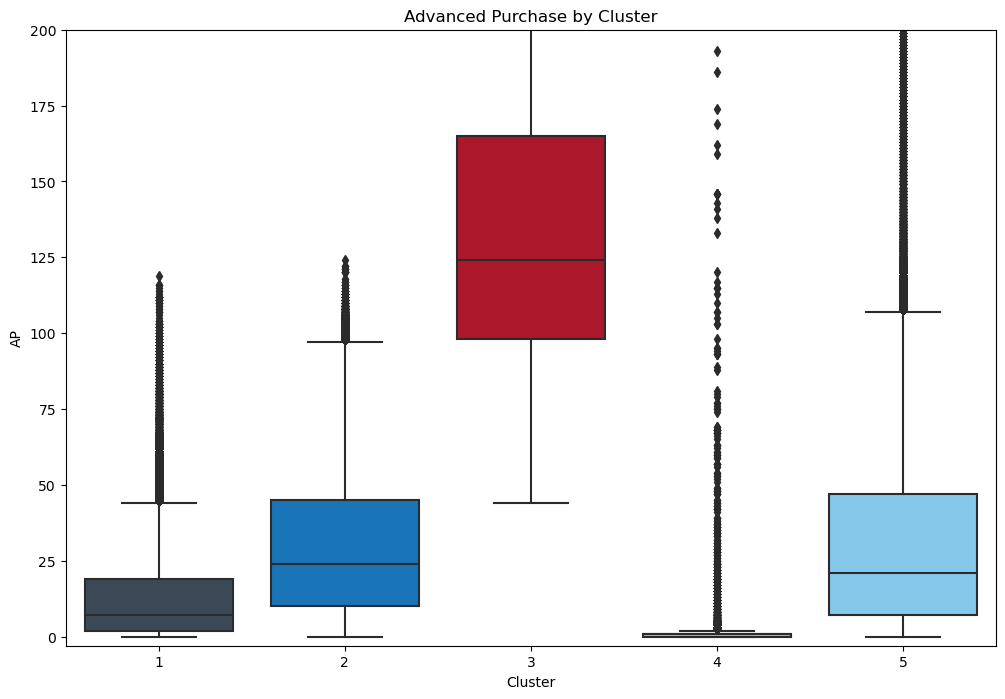

In [64]:
# Advanced Purchase
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='ADVANCED_PURCHASE', data=df, palette = custom_palette)
plt.title('Advanced Purchase by Cluster')
plt.xlabel('Cluster')
plt.ylabel('AP')
plt.ylim(-3, 200)
plt.show()

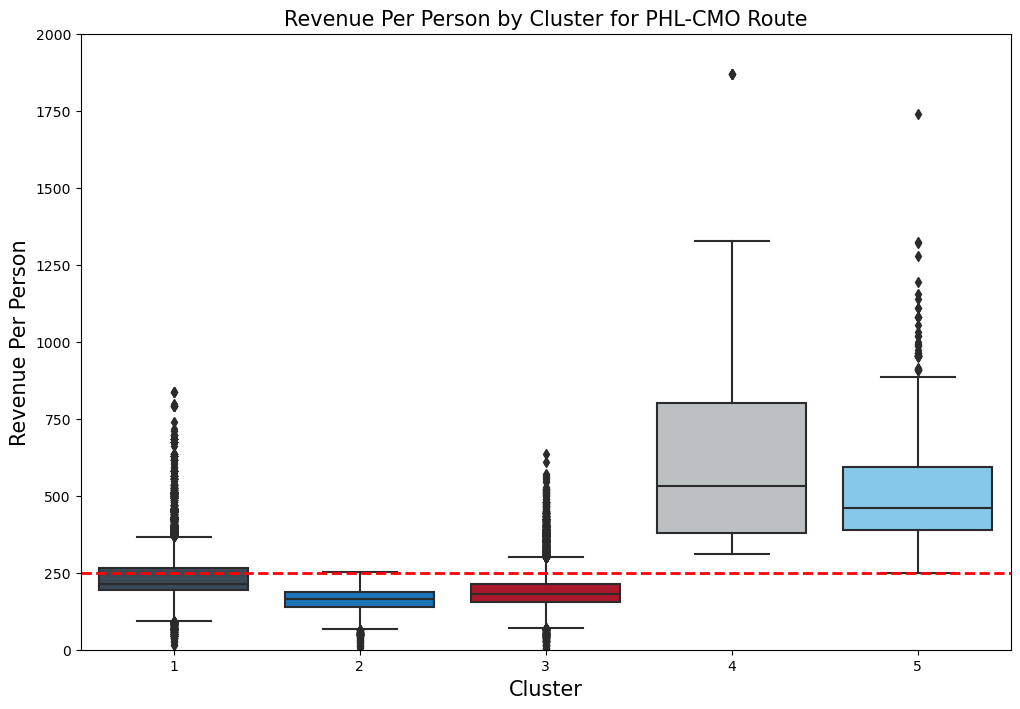

In [65]:
# Revenue Per Person by Cluster in PHL-MCO Sector
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='REVENUE_PER_PERSON', data = df[df['OD'] =='PHL-MCO'], palette = custom_palette)
plt.title('Revenue Per Person by Cluster for PHL-CMO Route', fontsize = 15)
plt.xlabel('Cluster', fontsize = 15)
plt.ylabel('Revenue Per Person', fontsize = 15)
plt.ylim(0, 2000)

# Horizontal red line at y=250
plt.axhline(y=250, color='red', linestyle='--', linewidth=2)

plt.show()

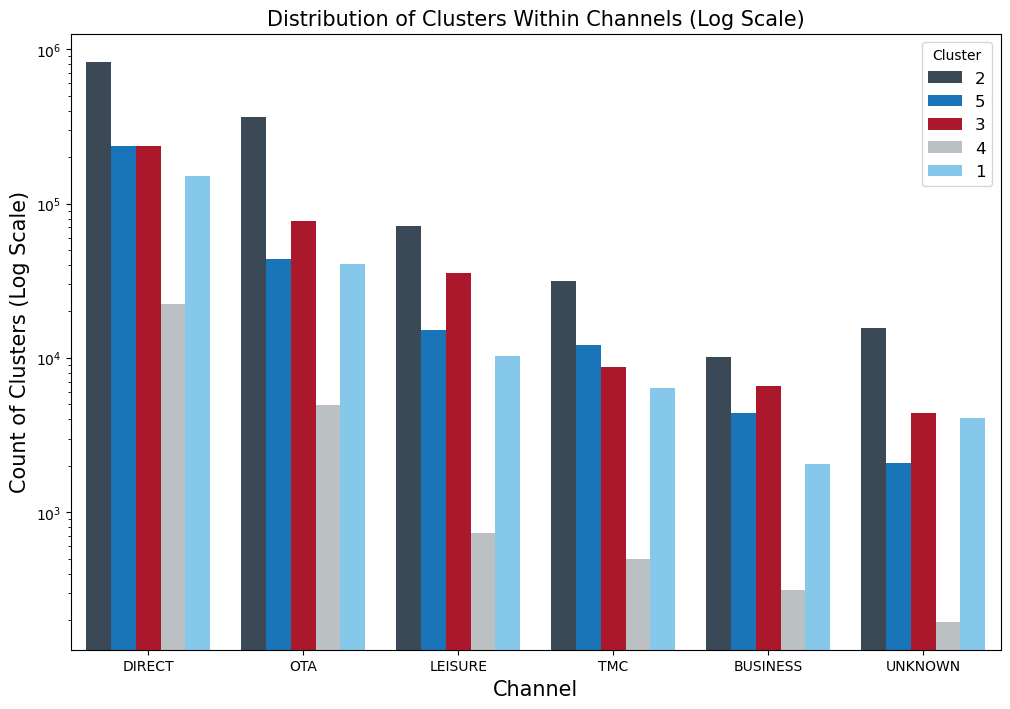

In [66]:
# Transform data type to avoid error 
df['Cluster'] = df['Cluster'].astype(str)  
df['CHANNEL'] = df['CHANNEL'].astype(str)  

#plotting
plt.figure(figsize=(12, 8))
sns.countplot(x='CHANNEL', hue='Cluster', data=df, palette=custom_palette)
plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.title('Distribution of Clusters Within Channels (Log Scale)', fontsize=15)
plt.xlabel('Channel', fontsize=15)
plt.ylabel('Count of Clusters (Log Scale)', fontsize=15)
plt.legend(title='Cluster', fontsize=12)
plt.show()

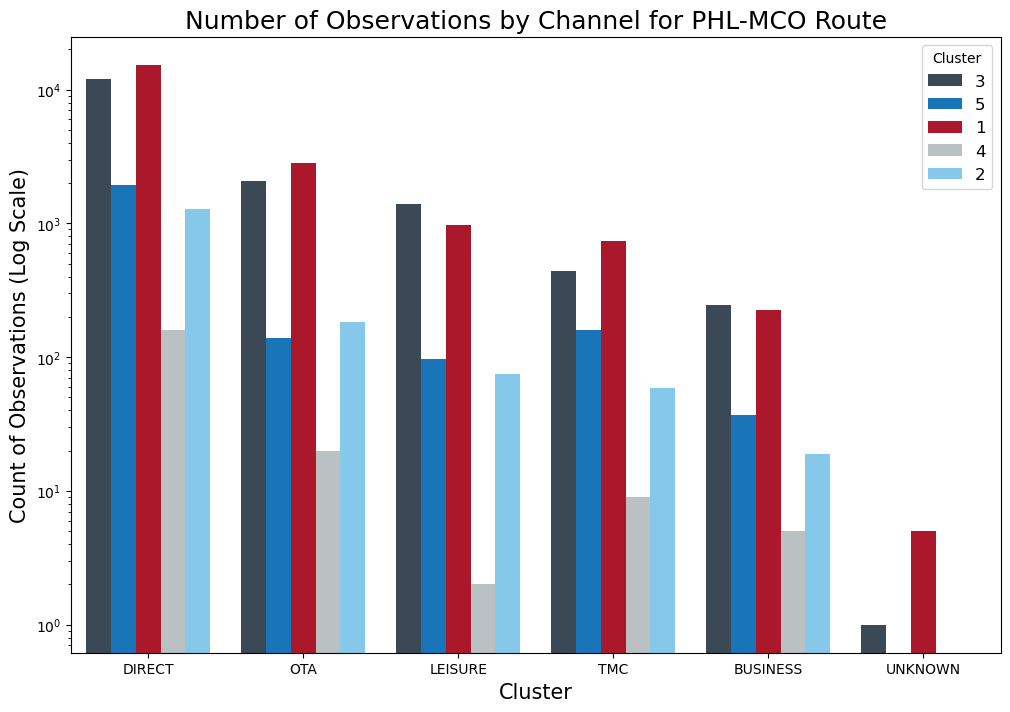

In [67]:
# Count plot for Number of Observations by Channel and Cluster with a log scale

# Filter the data for the PHL-MCO sector
filtered_data = df[df['OD'] == 'PHL-MCO']

plt.figure(figsize=(12, 8))
sns.countplot(x='CHANNEL', hue='Cluster', data=filtered_data, palette=custom_palette)
plt.title('Number of Observations by Channel for PHL-MCO Route', fontsize=18)
plt.xlabel('Cluster', fontsize=15)
plt.ylabel('Count of Observations (Log Scale)', fontsize=15)
plt.yscale('log')  # Apply a log scale to emphasize smaller counts
plt.legend(title='Cluster', fontsize=12)
plt.show()

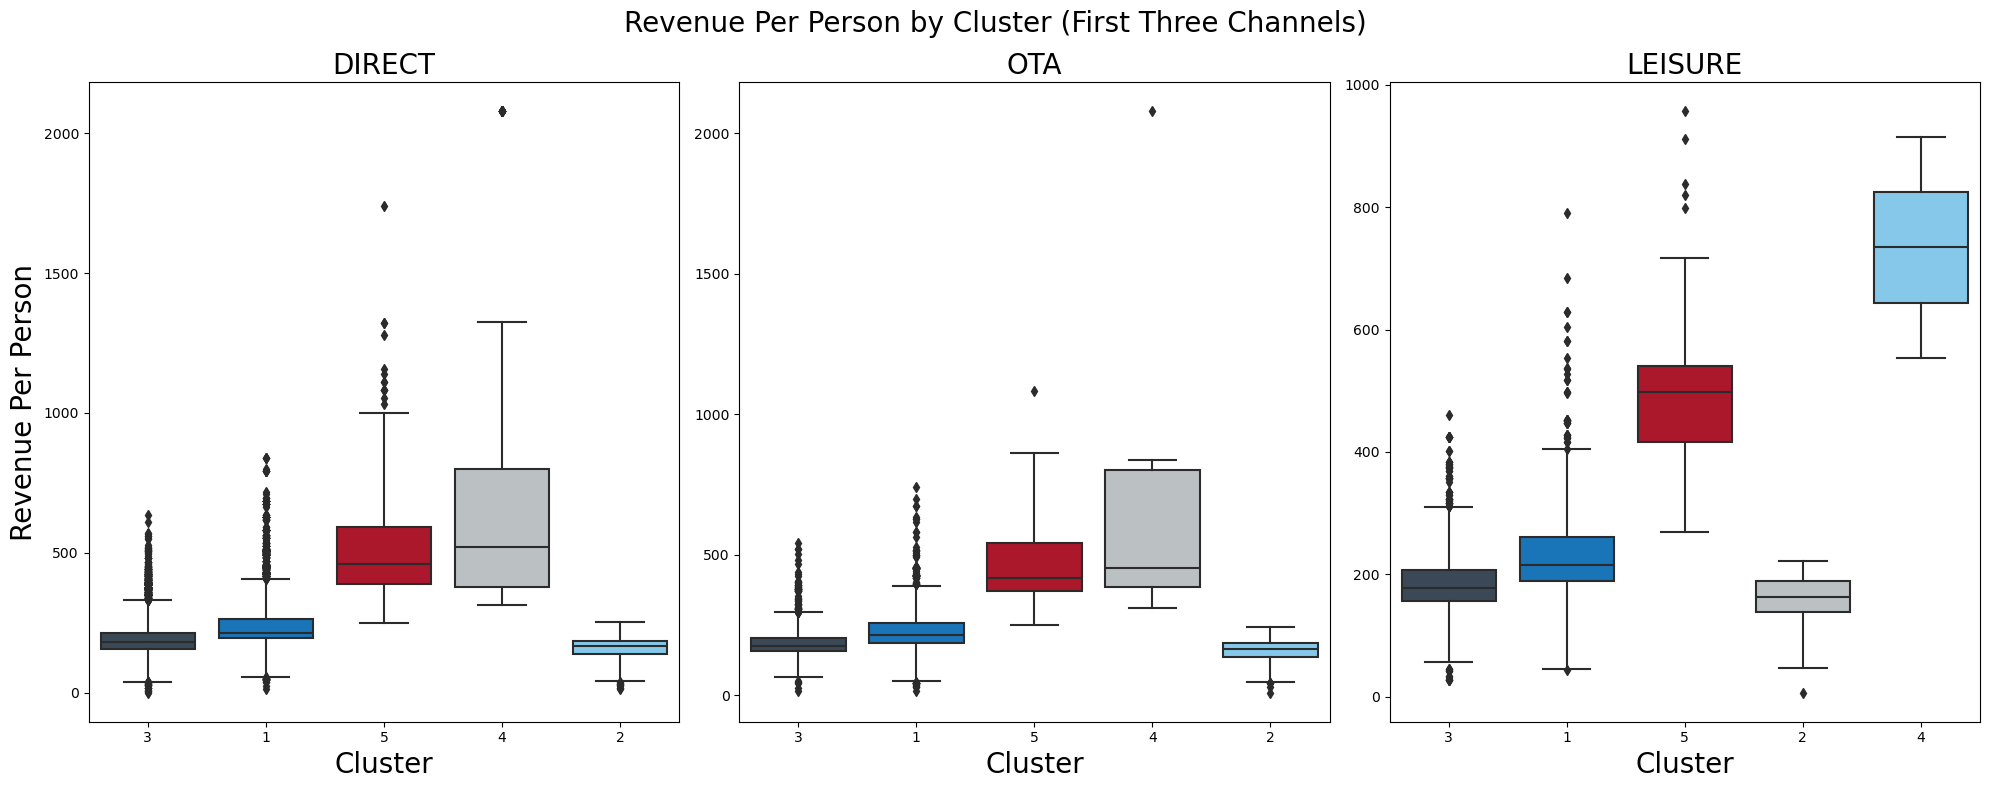

In [68]:
# Filter the data of the first three channels
filtered_data_first = filtered_data[filtered_data['CHANNEL'].isin(['DIRECT', 'OTA', 'LEISURE'])]

# Create a figure and plot each channel separately
plt.figure(figsize=(20, 8))

# Plot for 'DIRECT'
plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='REVENUE_PER_PERSON', data=filtered_data_first[filtered_data_first['CHANNEL'] == 'DIRECT'], palette=custom_palette, whis=2)
plt.title('DIRECT', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
plt.ylabel('Revenue Per Person', fontsize=20)

# Plot for 'OTA'
plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='REVENUE_PER_PERSON', data=filtered_data_first[filtered_data_first['CHANNEL'] == 'OTA'], palette=custom_palette, whis=2)
plt.title('OTA', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
plt.ylabel('')

# Plot for 'LEISURE'
plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='REVENUE_PER_PERSON', data=filtered_data_first[filtered_data_first['CHANNEL'] == 'LEISURE'], palette=custom_palette, whis=2)
plt.title('LEISURE', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
plt.ylabel('')

plt.suptitle("Revenue Per Person by Cluster (First Three Channels)", fontsize=20)
plt.tight_layout()
plt.show()

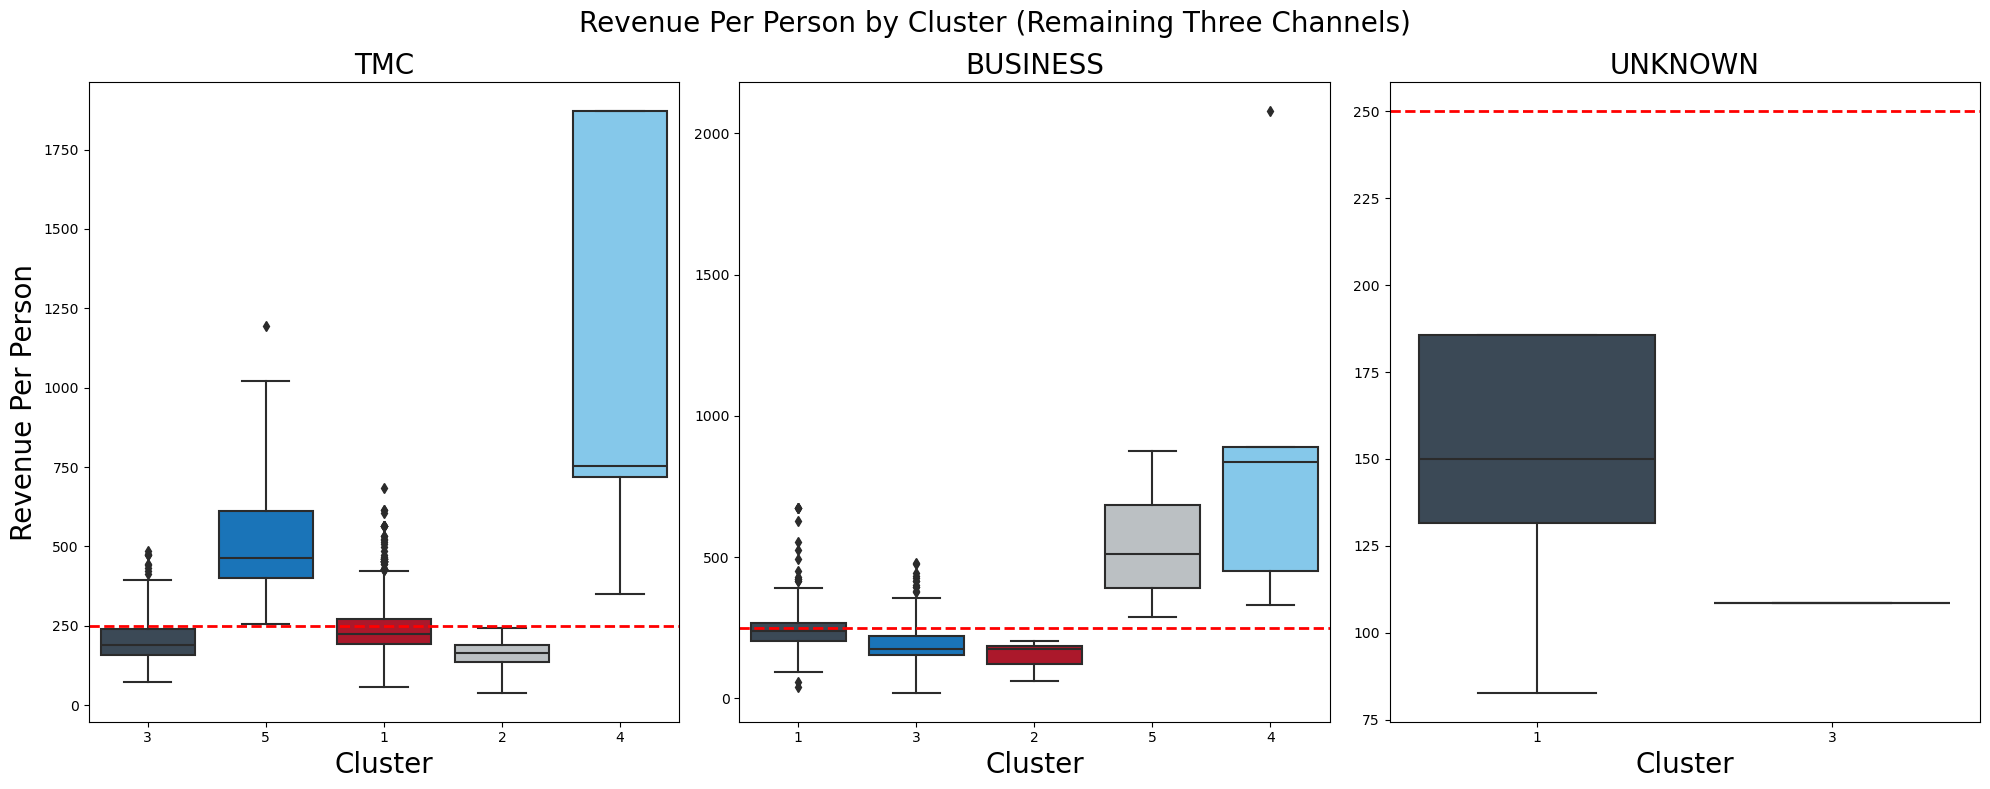

In [69]:
# Filter the data for the remaining three channels
filtered_data_second = filtered_data[filtered_data['CHANNEL'].isin(['TMC', 'BUSINESS', 'UNKNOWN'])]

# Create a figure and plot each channel separately
plt.figure(figsize=(20, 8))

# Plot for 'TMC'
plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='REVENUE_PER_PERSON', data=filtered_data_second[filtered_data_second['CHANNEL'] == 'TMC'], palette=custom_palette, whis=2)
plt.axhline(y=250, color='red', linestyle='--', linewidth=2)
plt.title('TMC', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
plt.ylabel('Revenue Per Person', fontsize=20)

# Plot for 'BUSINESS'
plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='REVENUE_PER_PERSON', data=filtered_data_second[filtered_data_second['CHANNEL'] == 'BUSINESS'], palette=custom_palette, whis=2)
plt.axhline(y=250, color='red', linestyle='--', linewidth=2)
plt.title('BUSINESS', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
plt.ylabel('')

# Plot for 'UNKNOWN'
plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='REVENUE_PER_PERSON', data=filtered_data_second[filtered_data_second['CHANNEL'] == 'UNKNOWN'], palette=custom_palette, whis=2)
plt.axhline(y=250, color='red', linestyle='--', linewidth=2)
plt.title('UNKNOWN', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
plt.ylabel('')

plt.suptitle("Revenue Per Person by Cluster (Remaining Three Channels)", fontsize=20)
plt.tight_layout()
plt.show()